In [58]:
import argparse, json, time, random
import hashlib, torch, math, pathlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import importlib, importlib.util, os
from sklearn.neighbors import KernelDensity

flexiblenetwork_color = "#006838"
rigidnetwork_color = "#97211F"
analyze_network = "final"  # options: "best", "final", <parameter update step no>
noise_amplitude = 0.1  # if run analyses with noise, noise amplitude
distractor_probability = 1.0
distractor_visible = False
show_figures = True  # True if running in jupyter notebook; False if running a .py file
running_from_data = True # True if code is running in the data folder next to the model.pth. if false, must run from training file
_task_is = [0, 1]
task_is = _task_is

n_networks = 20
directories = [f"data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r{i}/" for i in range(n_networks)]+\
    [f"data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcR_r{i}/" for i in range(n_networks)]+\
    [f"data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR+R_r{i}/" for i in range(n_networks)]
figure_dir_prefix = "paper_figures/"

In [55]:
def generate_generalization_figure(resolution = 720):
    task_is = np.linspace(-.5, 1.5, 21)
    rot_means, rot_sds = [], []
    rot_dots = []
    
    for task_i in task_is:
        resolution = resolution
        show_distractor = False
        noise_amplitude = 0.1
        
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        direction1s = []
        
        for direction1 in np.arange(resolution)/resolution*360:
            for direction2 in [0]:
                direction1s.append(direction1)
                i_full, o_full, b_mask = Task._make_trial(direction1, direction2, delay0, delay1, delay2, 0, show_distractor=show_distractor)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
        direction1s = np.array(direction1s)
        ao_input, ao_target, ao_mask = torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
        
        _t1 = delay0
        _t2 = delay0+task_parameters["show_direction_for"]+delay2
        _task_i = task_i
        ao_input[:, _t1:_t2, -1] = _task_i
        
        ao_noise_mask = Task.get_noise_mask(delay0, delay1, delay2)
        ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
        ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
        ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
        
        o1_o, o2_o = Task.convert_sincos_to_angles(ao_output, t5, t6)
        o1_t, o2_t = Task.convert_sincos_to_angles(ao_target, t5, t6)
        
        diff = np.abs(np.mean(o1_o.detach().numpy(), axis=1)-direction1s)
        diff = np.minimum(diff, np.abs(diff-360))
        diff = np.minimum(diff, np.abs(diff+360))
        diff = np.mean(o1_o.detach().numpy(), axis=1)-direction1s
        diff = np.mean(o1_o.detach().numpy(), axis=1)-np.mean(o1_t.detach().numpy(), axis=1)
        diff[diff > 180] -= 360
        diff[diff < -180] += 360
        rot_means.append(np.mean(diff))
        rot_sds.append(np.std(diff))
        rot_dots.append(diff)
    
    %matplotlib inline
    fig = plt.figure(figsize=(4, 4))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    plt.errorbar(task_is, rot_means, rot_sds, ecolor='black', capsize=3, color="black", linewidth=2)
    
    #for i, task_i in enumerate(task_is):
    #    plt.scatter([task_i]*len(rot_dots[i]), rot_dots[i], 3, c="gray")
        
    plt.fill_between([-.6, -.05], [-90, -90], [180, 180], color="gray", alpha=0.3)
    plt.fill_between([1.05, 1.6], [-90, -90], [180, 180], color="gray", alpha=0.3)
    
    plt.xlabel("stimulus")
    plt.ylabel("rotation angle (deg)")
    plt.xticks(np.linspace(0, 1, 3))
    plt.yticks([-30, 0, 30, 60, 90, 120, 180])
    plt.xlim(-.55, 1.55)
    plt.ylim(-45, 135)

    plt.tight_layout()
    plt.savefig(figure_dir_prefix+directory[5:-1] + f"_generalization.pdf", bbox_inches='tight')

def generate_MSD_figure(bandwidth=.1, t_from=0, t_to=-1, t=5, msd_max=0.8, analyze_outputs=True):
    msd_range = np.linspace(0, msd_max, 100)
    energy1, energy2 = generate_MSD_numbers(bandwidth=bandwidth, t_from=t_from, t_to=t_to, t=t, msd_max=msd_max, analyze_outputs=analyze_outputs)
    
    %matplotlib inline
    plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
    plt.close('all')
    fig = plt.figure(figsize=(6, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(msd_range, energy1, linewidth=3)
    ax2.plot(msd_range, energy2, linewidth=3)
    for ax in [ax1, ax2]:
        ax.set_xlabel("MSD")
        ax.set_ylim(-1.5, 2)
        ax.set_ylabel("Energy")
    ax1.set_title("no rotation")
    ax2.set_title("rotation")
    plt.tight_layout()
    plt.show()

def generate_MSD_numbers(bandwidth=.1, t_from=0, t_to=-1, t=5, msd_max=0.8, analyze_outputs=True):
    def energy_msd_dt(signal, t, msd_range, bandwidth=bandwidth):  # time range in dt
        res = np.zeros((len(msd_range), ))
        if len(signal.shape)==3: # n_trials x n_timesteps x n_neurons
            squared_displacement = torch.mean((signal[:, t:]-signal[:, :-t]) ** 2, dim=[2])**0.5
            # step 0: # n_trials x n_timesteps x n_neurons
            # step 1: # n_trials x (n_timesteps-5) x n_neurons
            # step 2: # n_trials x (n_timesteps-5)
            # step 3: # flatten ^^^
            # step 4: calculate KDE
            # step 5: convert probabilities to energy
            
            squared_displacement = squared_displacement.reshape(-1)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(squared_displacement.reshape(-1, 1))
        scores = -kde.score_samples(msd_range.reshape(-1, 1))
        res[:] = scores
        return res

    dt=1
    if analyze_outputs:
        data = ao_output[:, t_from:t_to].reshape(2, -1, t_to-t_from, 2)
    else:
        data = ao_h[:, t_from:t_to, :].reshape(2, -1, t_to-t_from, 100)
    data1 = data[0]
    data2 = data[1]
    data1 = data1 / (torch.sum(data1**2, dim=2)**0.5).unsqueeze(2)
    data2 = data2 / (torch.sum(data2**2, dim=2)**0.5).unsqueeze(2)
    
    msd_range = np.linspace(0, msd_max, 100)
    energy1 = energy_msd_dt(data1, t, msd_range)
    energy2 = energy_msd_dt(data2, t, msd_range)
    
    return energy1, energy2

In [56]:
energy_analysis_1s, energy_analysis_2s = [], []
bandwidth=.1
t=1
msd_max=0.5
analyze_outputs=True

for _directory in directories:
    print(_directory)
    directory = _directory
    
    # Define the file path and module name
    file_path = directory + "task_and_training.py"  # Change this to your file's path
    module_name = 'task_and_training'  # Arbitrary name for the module
    # Create a module object
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    # Load the module into memory and execute it
    spec.loader.exec_module(module)
    # Inject attributes into the global namespace
    for attr in dir(module):
        globals()[attr] = getattr(module, attr)
    directory = _directory  # it might have been changed by the imported file, so change it back
    task_is = _task_is  # it might have been changed by the imported file, so change it back
    
    with open(directory+f"info.json", 'r', encoding='utf-8') as f:
        j = json.load(f)
    hyperparameters = j["hyperparameters"]
    task_parameters = j["task_parameters"]
    model_parameters = j["model_parameters"]
    additional_comments = j["additional_comments"]
    directory = j["directory"]
    figures_directory="figures/"
    pathlib.Path(figures_directory+"a.a").parent.mkdir(parents=True, exist_ok=True)
    def save_figure(figure_name):
        plt.savefig(figures_directory+figure_name+".pdf")
        if show_figures: 
            plt.show()
        
    # some noise may be necessary to prevent dividing by 0 in some of the analyses
    # if noise_amplitude == 0: noise_amplitude = 0.0001
        
    model = Model()
    if analyze_network.lower() == "best": network_filename = "model_best.pth"
    elif analyze_network.lower() == "final": network_filename = f"model_parameterupdate{hyperparameters['train_for_steps']}.pth"
    else: network_filename = f"model_parameterupdate{analyze_network}.pth"
    model_state_dict = torch.load(directory+network_filename, map_location=torch.device('cpu'))["model_state_dict"]
    model.load_state_dict(model_state_dict)
    
    ORI_RES = 360/8
    ORI_SET = torch.arange(0, 360, ORI_RES)
    ORI_SET_SIZE = ORI_SET.shape[0]
    
    # fix delays at median values for analysis
    delay0, delay1, delay2 = Task.get_median_delays()
    show_direction_for = task_parameters["show_direction_for"]
    show_cue_for = task_parameters["show_cue_for"]
    total_time = show_direction_for+show_cue_for+delay0+delay2
    t1, t1d = delay0, "before O1 presented"
    t1_5, t1_5d = delay0+show_direction_for//2, "amid 01 presentation"
    t2, t2d = delay0+show_direction_for, "after O1 presented"
    t3, t3d = delay0+show_direction_for+delay1, "before O2 presented"
    t3_5, t3_5d = delay0+show_direction_for+delay1+show_direction_for//2, "amid O2 presentation"
    t4, t4d = delay0+show_direction_for+delay1+show_direction_for, "after O2 presented"
    t5, t5d = delay0+show_direction_for+delay2, "before go cue"
    t6, t6d = total_time-1, "at end of task"
    
    # run the model on all possible directions 
    def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=360//ORI_RES, show_distractor=True):
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        for task_i in task_is:
            for direction1 in np.arange(resolution)/resolution*360:
                for direction2 in np.arange(resolution)/resolution*360:
                    i_full, o_full, b_mask = Task._make_trial(direction1, direction2, delay0, delay1, delay2, task_i, show_distractor=show_distractor)
                    batch.append(i_full.unsqueeze(0))
                    batch_labels.append(o_full.unsqueeze(0))
                    output_masks.append(b_mask.unsqueeze(0))
        return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, show_distractor=distractor_visible)
    ao_noise_mask = Task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    # output model errors (with noise and without)
    mse_o1, mse_o2, err_o1, err_o2 = Task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    ao_output_nn, ao_h_nn = model.forward(ao_input, noise=ao_noise*0)
    mse_o1_nn, mse_o2_nn, err_o1_nn, err_o2_nn = Task.calculate_errors(ao_target, ao_output_nn, ao_mask, t5, t6)
    
    # for every timestep and every unit, calculate its activity in all trials
    ao_data = torch.zeros((2, total_time, model.dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
    for task_i in task_is:
        for direction1 in range(ORI_SET_SIZE):
            for direction2 in range(ORI_SET_SIZE):
                o = ao_h[task_i * ORI_SET_SIZE**2 + direction1 * ORI_SET_SIZE + direction2]
                ao_data[task_i][:, :, direction1, direction2] = o
            
    # detach from autograd
    ao_output = ao_output.detach()
    ao_h = ao_h.detach()
    ao_data = ao_data.detach()

    ################################################

    #generate_generalization_figure(resolution = 720)
    energy1, energy2 = generate_MSD_numbers(bandwidth=bandwidth, t_from=t1, t_to=t5, t=t, msd_max=msd_max, analyze_outputs=analyze_outputs)
    energy_analysis_1s.append(energy1)
    energy_analysis_2s.append(energy2)

    plt.close()

data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r0/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r1/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r2/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r3/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r4/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r5/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r6/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r7/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r8/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r9/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r10/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r11/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r12/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r13/
data/CTRNN_ROTATION_ra90_nir0_niw0_nrw0.1_ndt0_dr100_la0_tcNR_r14/
data/

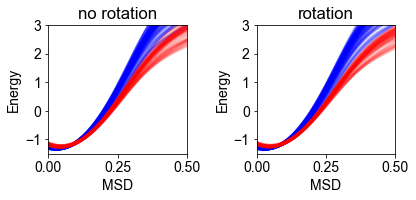

In [59]:
t_from=t1
t_to=t5
msd_range = np.linspace(0, msd_max, 100)

%matplotlib inline
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
plt.close('all')
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for i, energy1 in enumerate(energy_analysis_1s):
    directory = directories[i]
    if 'tcNR_' in directory or 'tcR_' in directory: color="blue"
    else: color = "red"

    energy1 = energy_analysis_1s[i]
    energy2 = energy_analysis_2s[i]
    ax1.plot(msd_range, energy1, linewidth=3, color=color, alpha=0.3)
    ax2.plot(msd_range, energy2, linewidth=3, color=color, alpha=0.3)
for ax in [ax1, ax2]:
    ax.set_xlabel("MSD")
    ax.set_ylim(-1.5, 3)
    ax.set_xlim(0, msd_max)
    ax.set_ylabel("Energy")
    ax.set_xticks([0, 0.25, 0.5])
    ax.set_yticks([-1, 0, 1, 2, 3])
ax1.set_title("no rotation")
ax2.set_title("rotation")
plt.tight_layout()
plt.savefig(figure_dir_prefix+f"_energy_landscape.pdf", bbox_inches='tight')